<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
!pip install --user pydotplus

     |████████████████████████████████| 286kB 16.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [2]:
import pydotplus

_Importing confusion matrix function_

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [4]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-09-10 13:04:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-09-10 13:04:11 (302 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

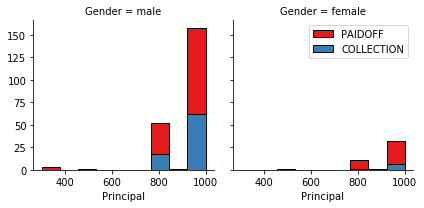

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

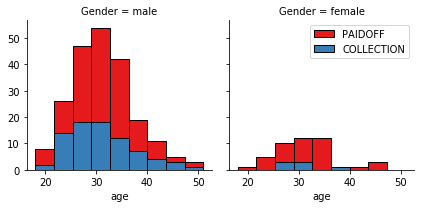

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

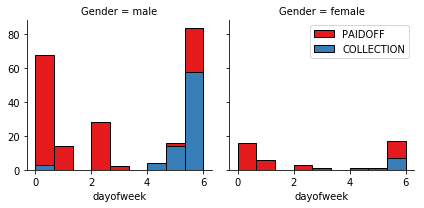

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True) # only 2 in this category
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


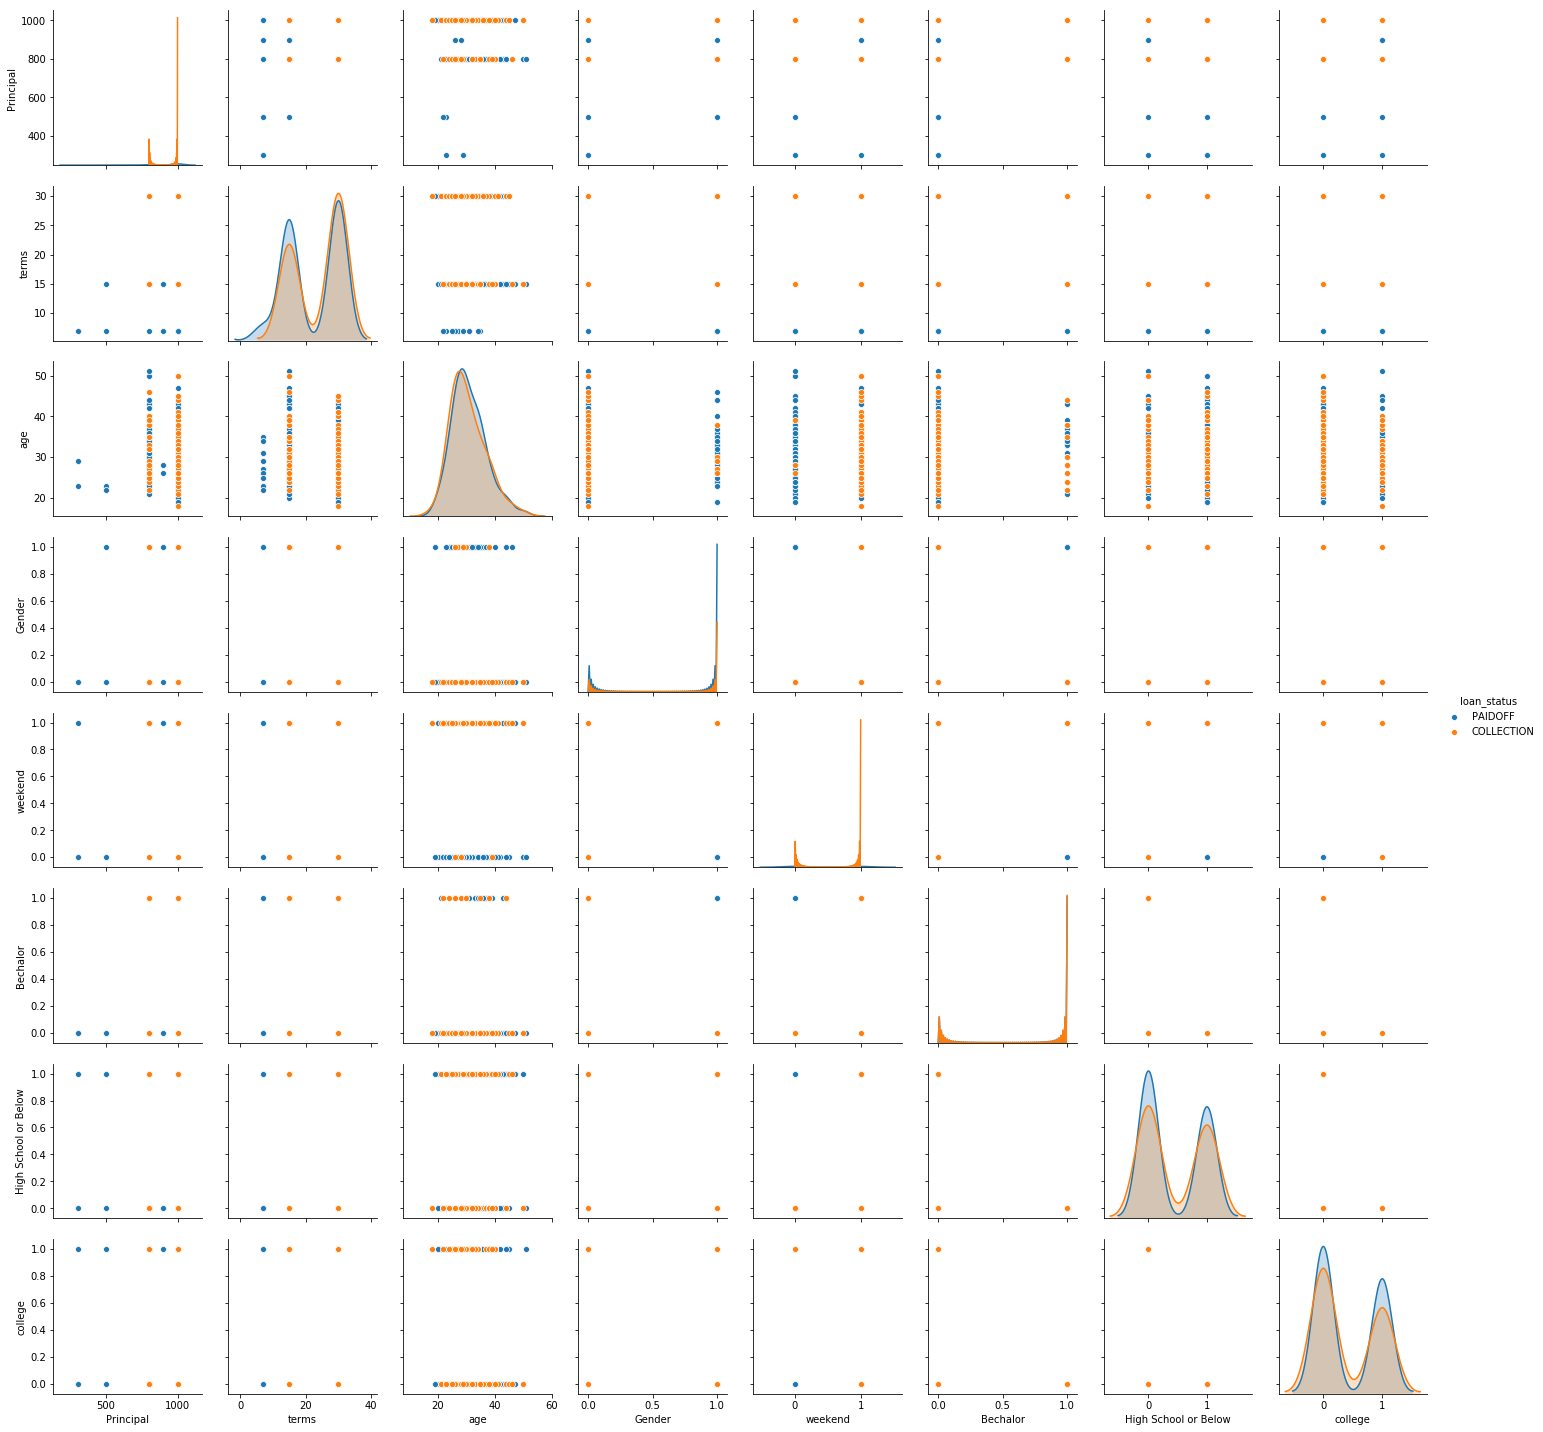

In [17]:
Feature_study=df[['Principal','terms','age','Gender','weekend','education','loan_status']]
Feature_study = pd.concat([Feature_study,pd.get_dummies(df['education'])], axis=1)
Feature_study.drop(['Master or Above'], axis = 1,inplace=True) # only 2 in this category
sns.pairplot(Feature_study, hue="loan_status")

### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## Different encoding for education descriptor

In [21]:
le_edu = preprocessing.LabelEncoder() #label encoder
Feature_b = df[['Principal','terms','age','Gender','weekend','education','loan_status']]
le_edu.fit(df['education'].unique().tolist())
Feature_b.iloc[:,5]= le_edu.transform(Feature_b.iloc[:,5]) 

Feature_b.head()

c:\Conda4\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Principal,terms,age,Gender,weekend,education,loan_status
0,1000,30,45,0,0,1,PAIDOFF
1,1000,30,33,1,0,0,PAIDOFF
2,1000,15,27,0,0,3,PAIDOFF
3,1000,30,28,1,1,3,PAIDOFF
4,1000,30,29,0,1,3,PAIDOFF


Let's visualise the dataset to check potential correlations

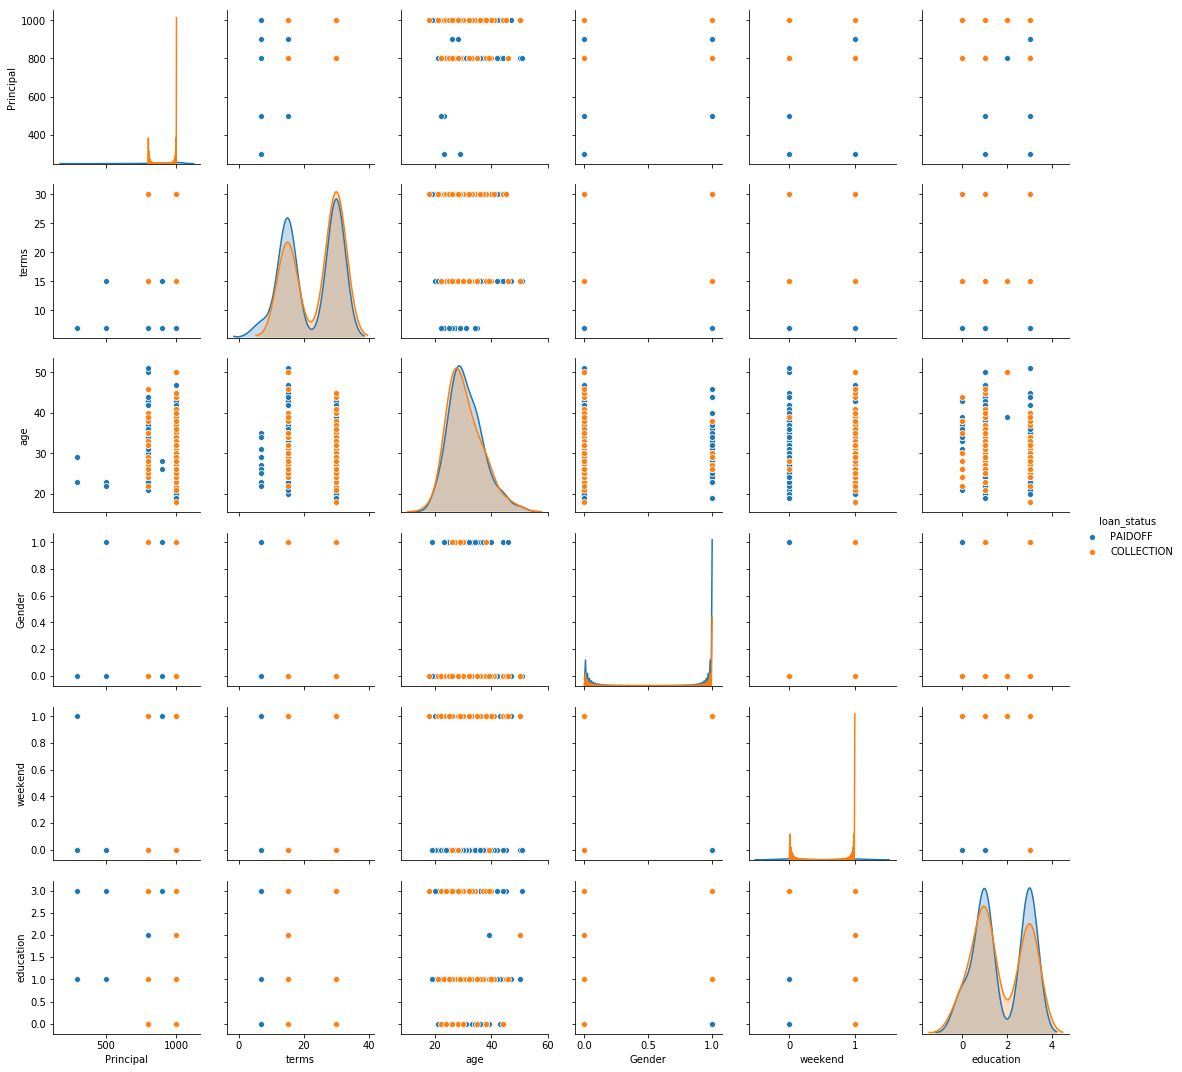

In [22]:
sns.pairplot(Feature_b, hue="loan_status")

In [23]:
X_b = Feature_b[['Principal','terms','age','Gender','weekend','education']]
y_b = Feature_b['loan_status'].values
X_b = preprocessing.StandardScaler().fit(X_b).transform(X_b)
X_b[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.64691859],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -1.5212695 ],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
         1.10178323],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         1.10178323],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         1.10178323]])

In [24]:
y_b[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

The data set used to train the model does not necessarily have to comprise all columns. We can test if the exclusion of some might produce a more precise model, especially for variables that do not show any particular correlation with the outcome.

In [26]:
X_set = X # the full dataset, in the one hot encoding case

# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y, test_size=0.2, random_state=1)

In [27]:
sum(y_test =='COLLECTION')

18

In [28]:
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
num_collections = np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')
    
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

In [29]:
sum(yhat =='COLLECTION')

2

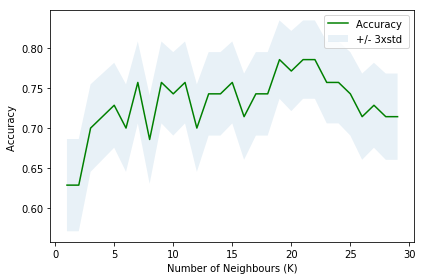

In [30]:
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

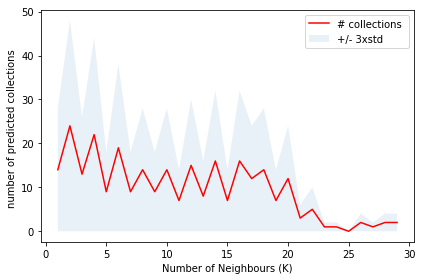

In [31]:
plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [32]:
print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)

The best accuracy was with 0.785714285714 with k= 19
the highest number of collection was 24.0 with k= 2


Will now test the dataset with alternative education encoding

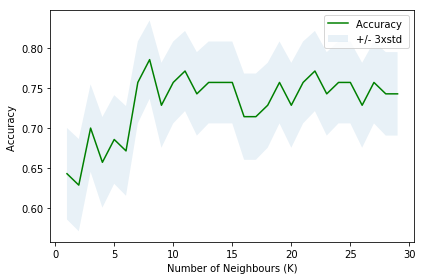

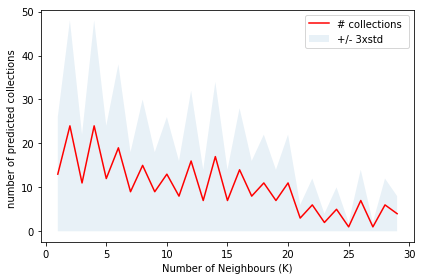

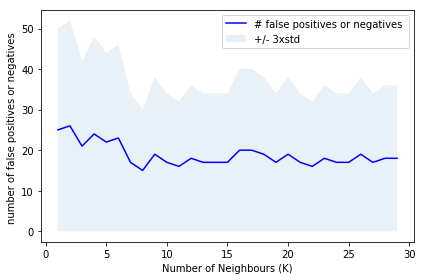

The best accuracy was with 0.785714285714 with k= 8
the highest number of collection was 24.0 with k= 2


In [33]:
X_set = X_b
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y_b, test_size=0.2, random_state=1)
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
num_collections = np.zeros((Ks-1))
false_res=np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')

    false_res[n-1]=confusion_matrix(y_test, yhat)[0,1]+confusion_matrix(y_test, yhat)[1,0]
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),false_res,'b')
plt.fill_between(range(1,Ks),false_res - 1 * false_res,false_res + 1 * false_res, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# false positives or negatives ', '+/- 3xstd'))
plt.ylabel('number of false positives or negatives ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)


We will now test some subsets.

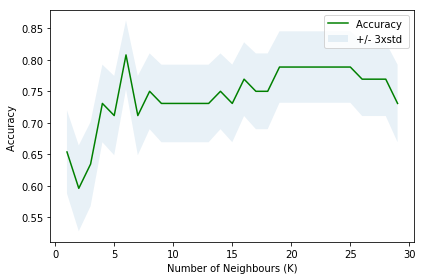

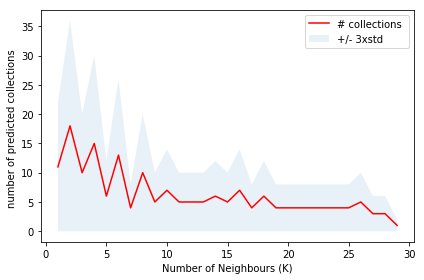

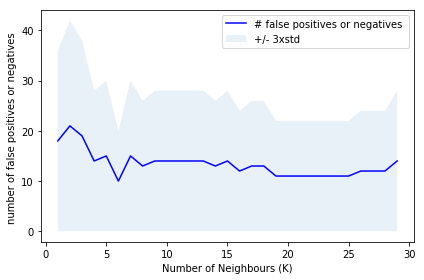

The best accuracy was with 0.807692307692 with k= 6
the highest number of collection was 18.0 with k= 2


In [34]:
X_set = X[:,np.r_[0:3,4:8]] # no gender, age, education [:,np.r_[0:3,4,5,6,7]]
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y, test_size=0.15, random_state=1)
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
num_collections = np.zeros((Ks-1))
false_res=np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')
    false_res[n-1]=confusion_matrix(y_test, yhat)[0,1]+confusion_matrix(y_test, yhat)[1,0]
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),false_res,'b')
plt.fill_between(range(1,Ks),false_res - 1 * false_res,false_res + 1 * false_res, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# false positives or negatives ', '+/- 3xstd'))
plt.ylabel('number of false positives or negatives ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)

In [35]:
print(yhat)
sum(yhat =='COLLECTION')

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


1

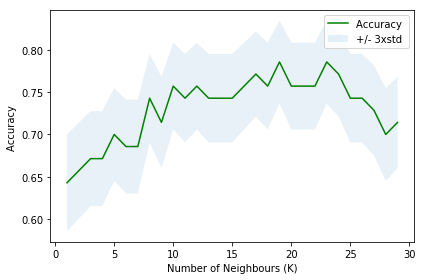

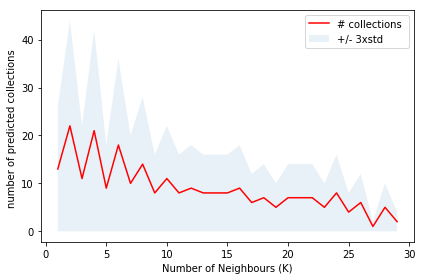

The best accuracy was with 0.785714285714 with k= 19
the highest number of collection was 22.0 with k= 2


In [36]:
X_set=X_b[:,np.r_[0:3,4:6]] # no gender, alternative education encoding
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y_b, test_size=0.2, random_state=1)
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')

    
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)

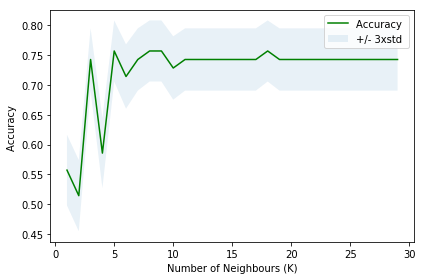

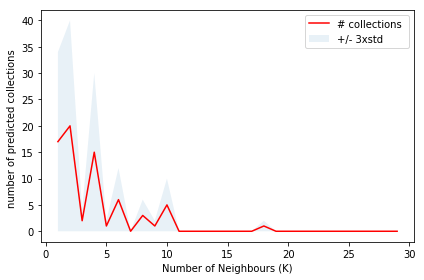

The best accuracy was with 0.757142857143 with k= 5
the highest number of collection was 20.0 with k= 2


In [37]:
X_set = X[:,np.r_[0:3,5]] # no education and gender indicator
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y, test_size=0.2, random_state=1)
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')
    
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)

In [38]:
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

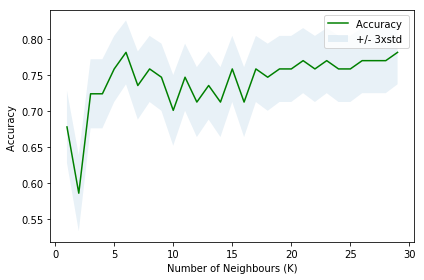

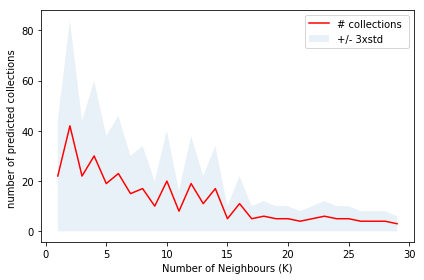

The best accuracy was with 0.781609195402 with k= 6
the highest number of collection was 42.0 with k= 2


In [39]:
# no education, gender
X_set=X_b[:,np.r_[0:3,4]]
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y_b, test_size=0.25, random_state=2)
Ks = 30

test_mean_acc = np.zeros((Ks-1))
test_std_acc = np.zeros((Ks-1))
ConfustionMx = []; 

for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat=KNN_model.predict(x_test)
    test_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) # calculating model accuracy with increasing value of k
    num_collections[n-1]= sum(yhat =='COLLECTION')
    
    test_std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),test_mean_acc,'g')

plt.fill_between(range(1,Ks),test_mean_acc - 1 * test_std_acc,test_mean_acc + 1 * test_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

plt.plot(range(1,Ks),num_collections,'r')

plt.fill_between(range(1,Ks),num_collections - 1 * num_collections,num_collections + 1 * num_collections, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('# collections ', '+/- 3xstd'))
plt.ylabel('number of predicted collections ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", test_mean_acc.max(), "with k=", test_mean_acc.argmax()+1) 
print("the highest number of collection was", num_collections.max(), "with k=", num_collections.argmax()+1)

The most promising models are obtained with the data set with onehot encoding, without the gender information, with k = 19. Alternatively the dataset with alternative education encoding shows slightly lower accuracy with k = 8. The dataset with no gender and education information shows lower accuracy, with optimal k = 5.

In [40]:
X_train = X[:,np.r_[0:3,4:8]] # no gender, nn 19
y_train = y

KNN_model_first = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)

In [41]:
X_train = X_b[:,np.r_[0:3,4]] # nn = 8
y_train = y_b

KNN_model_second = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)

In [42]:
X_train = X[:,np.r_[0:3,5]] # no gender and education, nn =5
y_train = y

KNN_model_third = KNeighborsClassifier(n_neighbors = 5).fit(X_train,y_train)

# Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
DT_loans = DecisionTreeClassifier(criterion="entropy", max_depth = 10) # define my model of decision tree
DT_loans.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Model trained used alternative encoding for education

In [45]:
DT_loans_b = DecisionTreeClassifier(criterion="entropy", max_depth = 10) # define my model of decision tree
DT_loans_b.fit(X_b,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

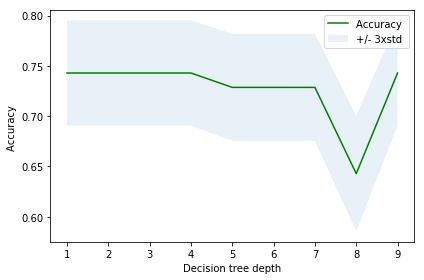

In [46]:
X_set = X # the full dataset, in the one hot encoding case

x_train, x_test, y_train, y_test = train_test_split( X_set, y, test_size=0.2, random_state=1)

dt_depth = 10
dt_mean_acc = np.zeros((dt_depth-1))
dt_std_acc= np.zeros((dt_depth-1))

for dt_d in range(1,dt_depth):
    DT_loans_opt = DecisionTreeClassifier(criterion="entropy", max_depth = dt_d)
    DT_loans_opt.fit(x_train,y_train)
    DT_pred = DT_loans_opt.predict(x_test)
    
    dt_mean_acc[dt_d-1] = metrics.accuracy_score(y_test, DT_pred)
    dt_std_acc[dt_d-1]=np.std(DT_pred==y_test)/np.sqrt(DT_pred.shape[0])
plt.plot(range(1,dt_depth),dt_mean_acc,'g')

plt.fill_between(range(1,dt_depth),dt_mean_acc - 1 * dt_std_acc,dt_mean_acc + 1 * dt_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Decision tree depth')
plt.tight_layout()
plt.show()

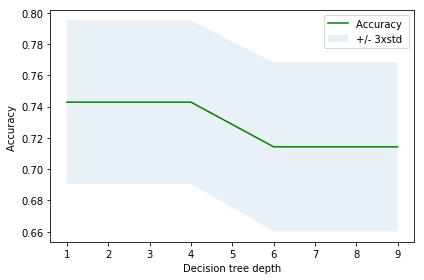

In [47]:
X_set = X_b
# divide into test and training set
x_train, x_test, y_train, y_test = train_test_split( X_set, y_b, test_size=0.2, random_state=1)
dt_depth = 10
dt_mean_acc = np.zeros((dt_depth-1))
dt_std_acc= np.zeros((dt_depth-1))

for dt_d in range(1,dt_depth):
    DT_loans_opt = DecisionTreeClassifier(criterion="entropy", max_depth = dt_d)
    DT_loans_opt.fit(x_train,y_train)
    DT_pred = DT_loans_opt.predict(x_test)
    
    dt_mean_acc[dt_d-1] = metrics.accuracy_score(y_test, DT_pred)
    dt_std_acc[dt_d-1]=np.std(DT_pred==y_test)/np.sqrt(DT_pred.shape[0])
plt.plot(range(1,dt_depth),dt_mean_acc,'g')

plt.fill_between(range(1,dt_depth),dt_mean_acc - 1 * dt_std_acc,dt_mean_acc + 1 * dt_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Decision tree depth')
plt.tight_layout()
plt.show()

# Support Vector Machine

In [48]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [49]:
y_enc = y
le_y = preprocessing.LabelEncoder() #label encoder
le_y.fit(np.unique(y_enc))
y_enc[:]= le_y.transform(y_enc[:]) 
y_enc = y_enc.astype('int')
X_set_svm = np.asarray(Feature)

In [50]:
loans_svm = svm.SVC(kernel='linear') #define the svm model
loans_svm.fit(X_set_svm, y_enc) # fit the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Model with alternative education encoding

In [51]:
X_b_svm = np.asarray(Feature_b[['Principal','terms','age','Gender','weekend','education']])
loans_svm_b = svm.SVC(kernel='linear') #define the svm model
loans_svm_b.fit(X_b_svm,y_enc) # fit the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y_enc)

Model with alternative education encoding

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR_b = LogisticRegression(C=0.01, solver='liblinear').fit(X_b,y_enc)

# Model Evaluation using Test set

In [54]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [55]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Test set for evaluation 

In [56]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [57]:
y_test_str =test_df['loan_status'].values

In [58]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) # x is the day indicator
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [59]:
X_test = test_Feature
y_test = test_df['loan_status'].values

Normalisation of test data

In [60]:
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

## Alternative encoding of the education field, on test data

In [61]:
le_edu = preprocessing.LabelEncoder() #label encoder
test_Feature_b = test_df[['Principal','terms','age','Gender','weekend','education','loan_status']]
le_edu.fit(test_df['education'].unique().tolist())
test_Feature_b.iloc[:,5]= le_edu.transform(test_Feature_b.iloc[:,5])

c:\Conda4\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [62]:
X_test_b = test_Feature_b[['Principal','terms','age','Gender','weekend','education']]
y_test_b = test_Feature_b[['loan_status']]
X_test_b = preprocessing.StandardScaler().fit(X_test_b).transform(X_test_b)
X_test_b[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
        -1.50366322],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
         0.22394984],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.63985669],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
         1.08775637],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
        -1.50366322]])

## K-NN

In [63]:
y_test_enc =y_test
y_test_enc[y_test_enc=='PAIDOFF'] = 1
y_test_enc[y_test_enc=='COLLECTION'] = 0
y_test_enc= y_test_enc.astype(int)

In the following cells three models are tested, according to the optimisation done in the train section.

In [64]:
X_set_first = X_test[:,np.r_[0:3,4:8]]

#df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#y_test_enc.replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

yhat_knn_first = KNN_model_first.predict(X_set_first)

yhat_knn_first[yhat_knn_first=='PAIDOFF'] = 1
yhat_knn_first[yhat_knn_first=='COLLECTION'] = 0
yhat_knn_first= yhat_knn_first.astype(int)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_knn_first))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_knn_first))

print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_knn_first))

Test set Accuracy:  0.666666666667
Test set Jaccard similarity score:  0.666666666667
Test set F1 score:  0.780487804878


In [65]:
confusion_matrix(y_test_enc, yhat_knn_first)

array([[ 4, 10],
       [ 8, 32]])

In [66]:
X_set_second = X_test_b[:,np.r_[0:3,4]]
#y_test
yhat_knn_second = KNN_model_second.predict(X_set_second)
print("Test set Accuracy: ", metrics.accuracy_score(y_test_b, yhat_knn_second))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_b, yhat_knn_second))

yhat_knn_second[yhat_knn_second=='PAIDOFF'] = 1
yhat_knn_second[yhat_knn_second=='COLLECTION'] = 0
yhat_knn_second= yhat_knn_second.astype(int)

y_test_b_enc = y_test_b
y_test_b_enc[y_test_b_enc=='PAIDOFF'] = 1
y_test_b_enc[y_test_b_enc=='COLLECTION'] = 0
y_test_b_enc= y_test_b_enc.astype(int)

print("Test set F1 score: ", metrics.f1_score(y_test_b_enc, yhat_knn_second))

Test set Accuracy:  0.722222222222
Test set Jaccard similarity score:  0.722222222222


c:\Conda4\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\Conda4\lib\site-packages\pandas\core\frame.py:2464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
c:\Conda4\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0

Test set F1 score:  0.823529411765


In [67]:
confusion_matrix(y_test_b_enc, yhat_knn_second)

array([[ 4, 10],
       [ 5, 35]])

In [96]:
# REMOVE

X_train = X[:,np.r_[0:5]] # no gender and education, nn =5
y_train = y_enc

KNN_model_third = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)

In [97]:
X_set_third =X_test[:,np.r_[0:5]]
#y_test
yhat_knn_third = KNN_model_third.predict(X_set_third)

#yhat_knn_third[yhat_knn_third=='PAIDOFF'] = 1
#yhat_knn_third[yhat_knn_third=='COLLECTION'] = 0
#yhat_knn_third= yhat_knn_third.astype(int)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_knn_third))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_knn_third))
print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_knn_third))

Test set Accuracy:  0.722222222222
Test set Jaccard similarity score:  0.722222222222
Test set F1 score:  0.823529411765


In [70]:
confusion_matrix(y_test_enc, yhat_knn_third)

array([[ 4, 10],
       [ 5, 35]])

## Decision Tree

In [71]:
DT_loans = DecisionTreeClassifier(criterion="entropy", max_depth = 8) # define my model of decision tree
DT_loans.fit(X,y_enc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [98]:
#DT_loans
#DT_loans_b
DT_loans_pred = DT_loans.predict(X_test) # predict on test set
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_enc, DT_loans_pred))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, DT_loans_pred))
#DT_loans_pred[DT_loans_pred=='PAIDOFF'] = 1
#DT_loans_pred[DT_loans_pred=='COLLECTION'] = 0
#DT_loans_pred= DT_loans_pred.astype(int)
print("Test set F1 score: ", metrics.f1_score(y_test_enc, DT_loans_pred))

DecisionTrees's Accuracy:  0.796296296296
Test set Jaccard similarity score:  0.796296296296
Test set F1 score:  0.873563218391


In [73]:
from sklearn.externals.six import StringIO
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

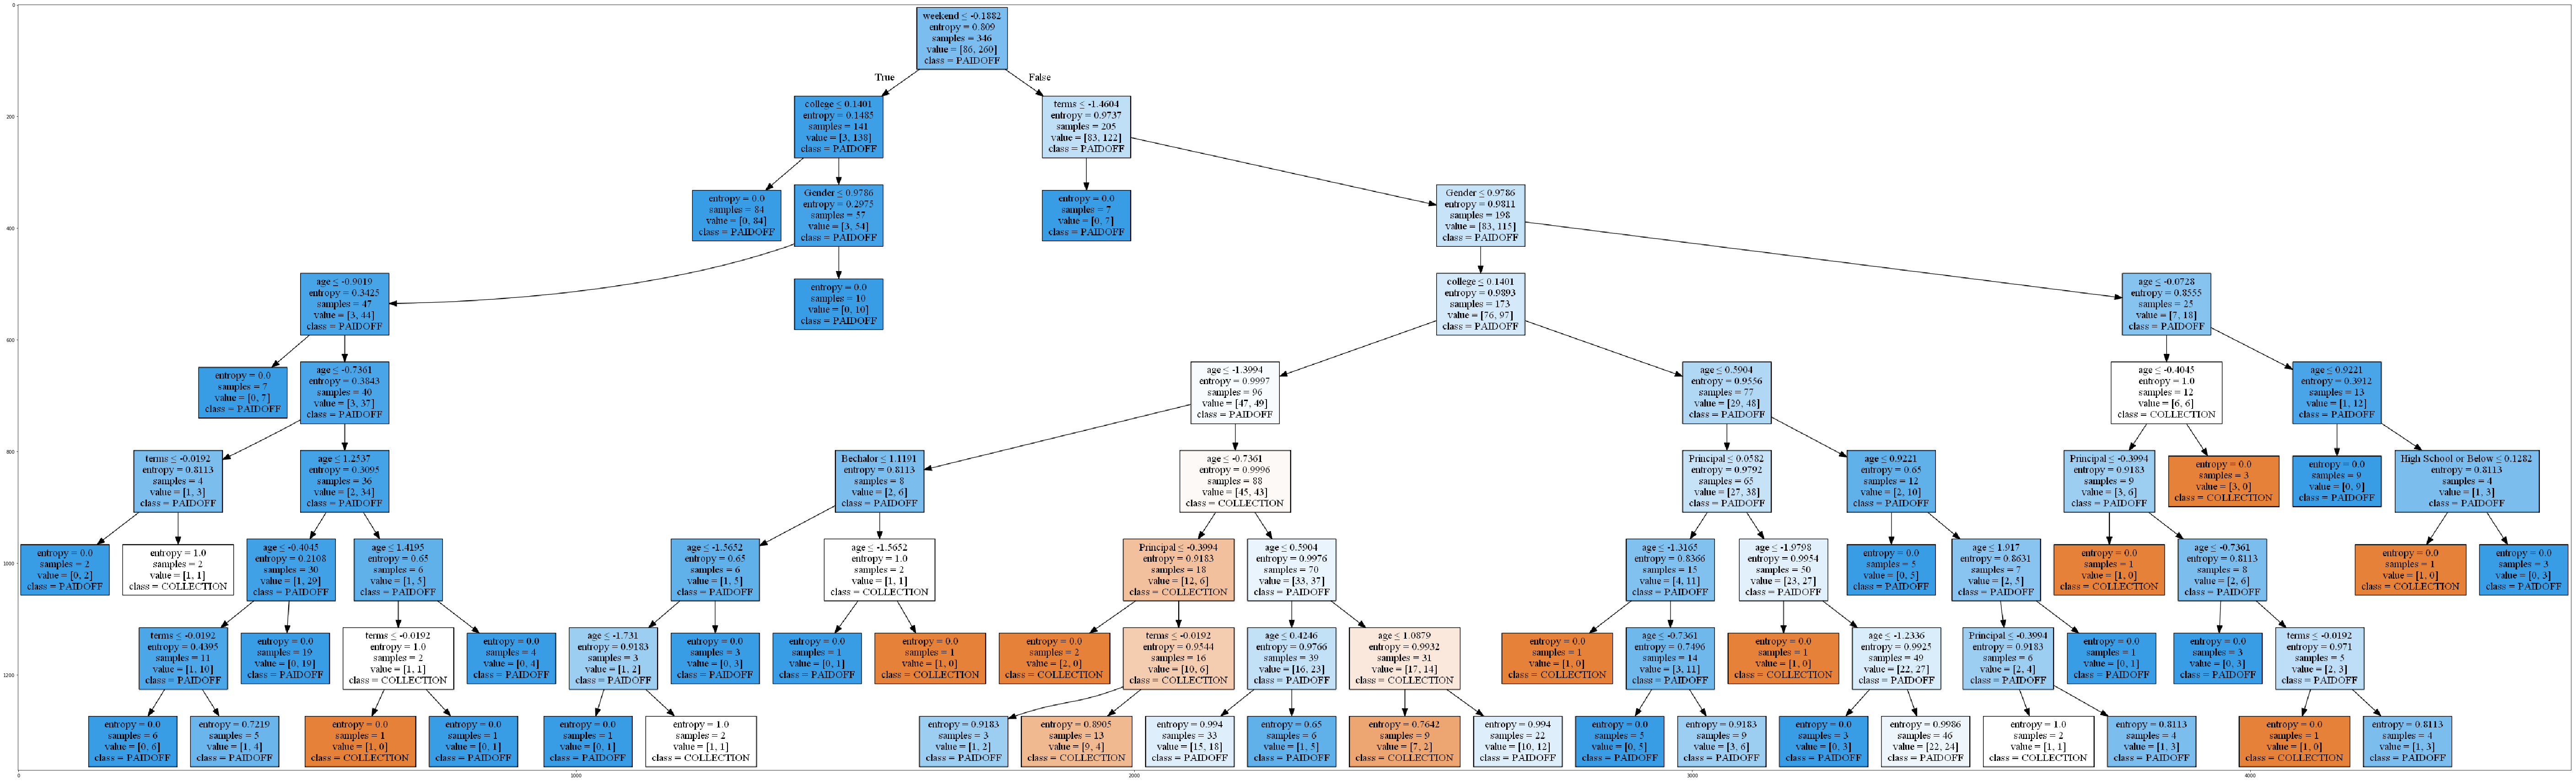

In [74]:
dot_data = StringIO()
filename = "assignment_DT_ent_maxdepth_8.png"
featureNames = Feature.columns[:]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(DT_loans,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_test_str), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [75]:
DT_loans_b = DecisionTreeClassifier(criterion="entropy", max_depth = 8) # define my model of decision tree
DT_loans_b.fit(X_b,y_enc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [77]:
DT_loans_b_pred = DT_loans_b.predict(X_test_b) # predict on test set
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_enc, DT_loans_b_pred))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, DT_loans_b_pred))
#DT_loans_b_pred[DT_loans_b_pred=='PAIDOFF'] = 1
#DT_loans_b_pred[DT_loans_b_pred=='COLLECTION'] = 0
#DT_loans_b_pred= DT_loans_b_pred.astype(int)
print("Test set F1 score: ", metrics.f1_score(y_test_enc, DT_loans_b_pred))

DecisionTrees's Accuracy:  0.796296296296
Test set Jaccard similarity score:  0.796296296296
Test set F1 score:  0.873563218391


### Optimisation

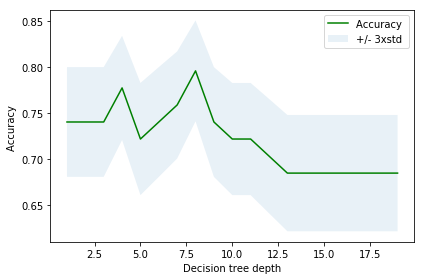

In [78]:
dt_depth = 20
dt_mean_acc = np.zeros((dt_depth-1))
dt_std_acc= np.zeros((dt_depth-1))

for dt_d in range(1,dt_depth):
    DT_loans_opt = DecisionTreeClassifier(criterion="entropy", max_depth = dt_d)
    DT_loans_opt.fit(X_b,y_enc)
    DT_pred = DT_loans_opt.predict(X_test_b)
    
    dt_mean_acc[dt_d-1] = metrics.accuracy_score(y_test_enc, DT_pred)
    dt_std_acc[dt_d-1]=np.std(DT_pred==y_test)/np.sqrt(DT_pred.shape[0])
plt.plot(range(1,dt_depth),dt_mean_acc,'g')

plt.fill_between(range(1,dt_depth),dt_mean_acc - 1 * dt_std_acc,dt_mean_acc + 1 * dt_std_acc, alpha=0.10) # fill_between creates the shading, as wide as std dev
# alpha changes shading darkness
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Decision tree depth')
plt.tight_layout()
plt.show()

## SVM

In [79]:
loans_svm = svm.SVC(kernel='rbf', gamma = 'scale') #define the svm model
loans_svm.fit(X_set_svm, y_enc) # fit the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [80]:
yhat_svm =loans_svm.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_svm))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_svm))
print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_svm))

DecisionTrees's Accuracy:  0.7407407407407407
Test set Jaccard similarity score:  0.7407407407407407
Test set F1 score:  0.851063829787234


In [81]:
yhat_svm_b =loans_svm_b.predict(X_test_b)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_svm_b))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_svm_b))
print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_svm_b))

DecisionTrees's Accuracy:  0.7407407407407407
Test set Jaccard similarity score:  0.7407407407407407
Test set F1 score:  0.851063829787234


### Optimisation

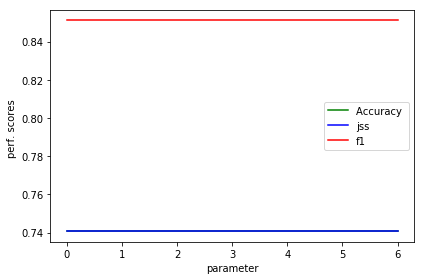

In [79]:
param = [0, 1, 2, 3, 4, 5, 6]
svm_acc=[]
svm_jss=[]
svm_fone=[]
for gamma in param:
    loans_svm_test = svm.SVC(kernel='rbf', degree=gamma) #define the svm model
    loans_svm_test.fit(X_set_svm, y_enc) # fit the model

    yhat_svm =loans_svm_test.predict(X_test)
    svm_acc.append(metrics.accuracy_score(y_test_enc, yhat_svm))
    svm_jss.append(metrics.jaccard_similarity_score(y_test_enc, yhat_svm))
    svm_fone.append(metrics.f1_score(y_test_enc, yhat_svm))
    

plt.plot(param,svm_acc,'g')
plt.plot(param,svm_jss,'b')
plt.plot(param,svm_fone,'r')

plt.legend(('Accuracy ', 'jss', 'f1'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

cycled gamma with linear kernel, no impact on accuracy or other scores; same with rbf; poly blocks core;

c does not matter as well

## Logistic regression

### Optimisation

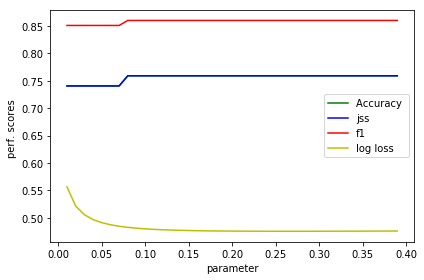

In [81]:
param = np.arange(0.01,0.4,0.01)
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(C=q, solver='liblinear').fit(X,y_enc)

    yhat_LR =LR.predict(X_test)
    yhat_LR_prob = LR.predict_proba(X_test)
    LR_acc.append(metrics.accuracy_score(y_test_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

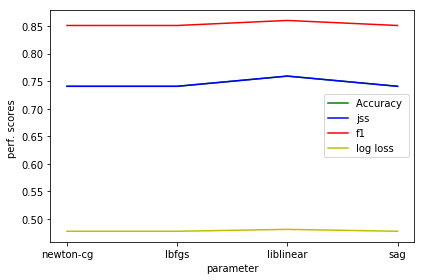

In [82]:
param = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(C=0.09, solver=q).fit(X,y_enc)

    yhat_LR =LR.predict(X_test)
    yhat_LR_prob = LR.predict_proba(X_test)
    LR_acc.append(metrics.accuracy_score(y_test_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

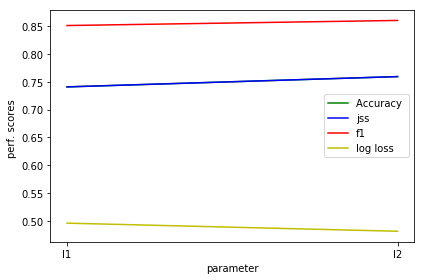

In [84]:
param = ['l1', 'l2']
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(penalty = q, C=0.09, solver='liblinear').fit(X,y_enc)

    yhat_LR =LR.predict(X_test)
    yhat_LR_prob = LR.predict_proba(X_test)
    LR_acc.append(metrics.accuracy_score(y_test_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

Optimisation of model with alternative education encoding

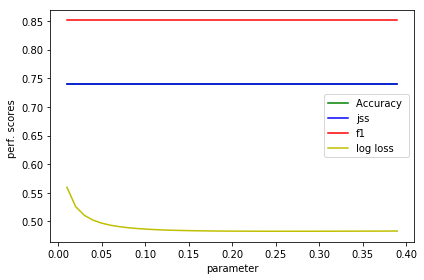

In [85]:
param = np.arange(0.01,0.4,0.01)
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(C=q, solver='liblinear').fit(X_b,y_enc)

    yhat_LR =LR.predict(X_test_b)
    yhat_LR_prob = LR.predict_proba(X_test_b)
    LR_acc.append(metrics.accuracy_score(y_test_b_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_b_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_b_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_b_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

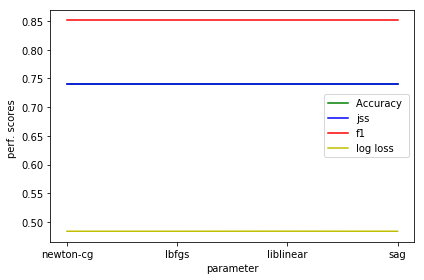

In [86]:
param = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(C=0.15, solver=q).fit(X_b,y_enc)

    yhat_LR =LR.predict(X_test_b)
    yhat_LR_prob = LR.predict_proba(X_test_b)
    LR_acc.append(metrics.accuracy_score(y_test_b_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_b_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_b_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_b_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

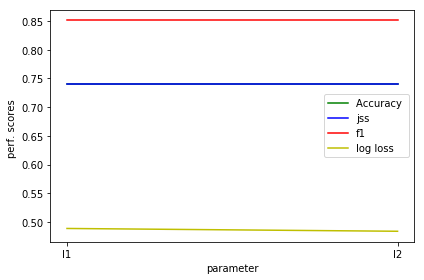

In [87]:
param = ['l1', 'l2']
LR_acc=[]
LR_jss=[]
LR_fone=[]
LR_LL=[]

for q in param:
    LR = LogisticRegression(penalty=q,C=0.15, solver='liblinear').fit(X_b,y_enc)

    yhat_LR =LR.predict(X_test_b)
    yhat_LR_prob = LR.predict_proba(X_test_b)
    LR_acc.append(metrics.accuracy_score(y_test_b_enc, yhat_LR))
    LR_jss.append(metrics.jaccard_similarity_score(y_test_b_enc, yhat_LR))
    LR_fone.append(metrics.f1_score(y_test_b_enc, yhat_LR))
    LR_LL.append(metrics.log_loss(y_test_b_enc, yhat_LR_prob))

plt.plot(param,LR_acc,'g')
plt.plot(param,LR_jss,'b')
plt.plot(param,LR_fone,'r')
plt.plot(param,LR_LL,'y')

plt.legend(('Accuracy ', 'jss', 'f1', 'log loss'))
plt.ylabel('perf. scores ')
plt.xlabel('parameter')
plt.tight_layout()
plt.show()

### Optimal values

In [88]:
LR = LogisticRegression(penalty = 'l2', C=0.15, solver='liblinear').fit(X,y_enc)
LR_b = LogisticRegression(penalty = 'l2', C=0.15, solver='liblinear').fit(X_b,y_enc)

In [92]:
yhat_LR =LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)
print("SVM's Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_LR))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_LR))
print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_LR))
print("Test set log loss: ", metrics.log_loss(y_test_enc, yhat_LR_prob))

SVM's Accuracy:  0.759259259259
Test set Jaccard similarity score:  0.759259259259
Test set F1 score:  0.860215053763
Test set log loss:  0.47695465616


In [91]:
yhat_LR_b = LR_b.predict(X_test_b)
yhat_LR_b_prob = LR_b.predict_proba(X_test_b)
print("SVM's Accuracy: ", metrics.accuracy_score(y_test_enc, yhat_LR_b))
print("Test set Jaccard similarity score: ", metrics.jaccard_similarity_score(y_test_enc, yhat_LR_b))
print("Test set F1 score: ", metrics.f1_score(y_test_enc, yhat_LR_b))
print("Test set log loss: ", metrics.log_loss(y_test_enc, yhat_LR_b_prob))

SVM's Accuracy:  0.740740740741
Test set Jaccard similarity score:  0.740740740741
Test set F1 score:  0.851063829787
Test set log loss:  0.483973095334


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72       | 0.82        | NA      |
| Decision Tree      | 0.80       | 0.87        | NA      |
| SVM                | 0.74       | 0.85        | NA      |
| LogisticRegression | 0.76       | 0.86        | 0.48       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>